In [49]:
# Bibliotecas  auxiliares
import pandas as pd
import numpy as np

# Ler e visualizar as imagens
import matplotlib.pyplot as plt
%matplotlib inline

# Criar um teste de validação
from sklearn.model_selection import train_test_split

# Testar a acurácia do modelo
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch bibliotecas e módulos
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

#Copiar arquivos
import shutil

In [50]:
#Provavelmente colocar em cada época:
#torch.cuda.empty_cache

def unpickle(file_path):
  import pickle 
  
  with open(file_path, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

In [51]:
file_path = '/content/drive/MyDrive/PytorchCNN/cifar-10-batches-py/test_batch'

In [52]:
current_data_batch = unpickle(file_path)

data = np.array(current_data_batch[b'data'])
labels = np.array(current_data_batch[b'labels'])

data = data/255
print(data.shape)
print(labels)

(10000, 3072)
[3 8 8 ... 5 1 7]


In [53]:
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
print(data.shape)

(10000, 32, 32, 3)


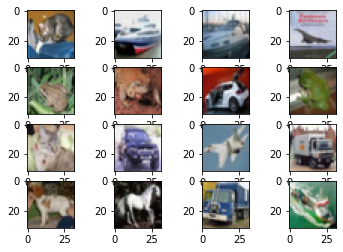

In [54]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(data[i])

plt.show()

In [55]:
# Convertendo os numpy array para formato torch
test_x = data.transpose(0, 3, 1, 2)

# Imagens que serão entradas para o Teste
test_x  = torch.from_numpy(test_x)

# ID's que serão saídas para o Teste
labels = torch.from_numpy(labels)

sample = torch.as_tensor(test_x, dtype=torch.float32)

# torch([45000, 32, 32, 3])
sample.shape, labels.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000]))

In [56]:
def load_ckp(checkpoint_fpath, model, optimizer):
    
    # Carregar o checkpoint
    checkpoint = torch.load(checkpoint_fpath)
    
    # Inicializar o state dict do checkpoint para o módulo
    model.load_state_dict(checkpoint['state_dict'])
    # Inicializar o otimizaodr do checkpoint para o módulo
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Inicializar valid_loss_min do checkpoint para valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']

    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class Net(Module):   
   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [58]:
model = Net()

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    model = model.cuda()
    
print(model)

# define optimzer
optimizer = Adam(model.parameters(), lr=0.07)

# define checkpoint saved path
ckp_path = "/content/drive/MyDrive/PytorchCNN/melhor_modelo/best_model.pt"


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [59]:
model, optimizer, start_epoch, valid_loss_min = load_ckp(ckp_path, model, optimizer)

In [60]:
print("Modelo = ", model)
print("Optmizer = ", optimizer)
print("Epoca = ", start_epoch)
print("Valid Loss = ", valid_loss_min)


Modelo =  Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Optmizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.07
    weight_decay: 0
)
Epoca =  14
Valid Loss =  2.303419828414917


In [76]:
model.eval()

with torch.no_grad():
        
  output = model(sample)
  pred = torch.max(output, 1)

print(labels[:30])
print(pred[1][:30])

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3])
